# Model Training 

### Import Dependencies

In [2]:
import os
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Audio
import soundfile as sf
import sklearn.linear_model
import sklearn.preprocessing
import sklearn.metrics
from multiprocessing import Pool
import random

random.seed(42)

### Loading Data
Currently, I will be using ASVspoof 2019 dataset which is a dataset containing real (bonafide) and fake (spoofed) speech generated from a variety of methods. 

In [3]:
data_path = '../data/ASVspoof_Dataset/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt'
df = pd.read_csv(data_path, delimiter=" ", names=["SPEAKER_ID", "AUDIO_FILE_NAME", "SYSTEM_ID", "-", "KEY"])

### Extracting MFCC Features
This function will extract 25 different mfcc features from each file, and calculate the mean and standard deviation. Then, it will concatnate all values into a single vector.
This snippet also use multiprocessing to speed up the process in parallel.

In [4]:
from mfcc_extraction import extract_mfcc
training_file_path = '../data/ASVspoof_Dataset/ASVspoof2019_LA_train/flac/'

features = []
if __name__ == '__main__':
    with Pool(os.cpu_count()) as p:
        features = p.map(extract_mfcc, training_file_path + df['AUDIO_FILE_NAME'].to_numpy() + ".flac")
        features = np.array(features)

In [5]:
labels = np.array(df['KEY'].map(lambda x: x == 'bonafide'))

### Data Normalization
We will use Standard Scaler to normalize our data.
This calculates the z-score or the number of standard deviations a value is from a mean.

z = (x - u) / s
Where x is the value to be normalized, u is the mean, and s is the standard deviation.

In [6]:
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(features)
scaled_featues = scaler.transform(features)

### Build the Model
We will being a logistic regression model for now.

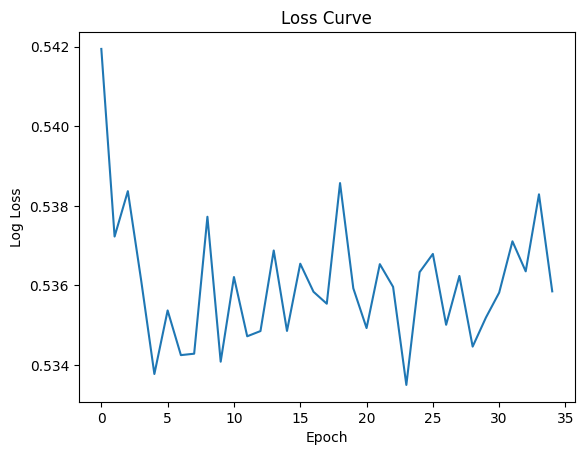

In [7]:
n_epoch = 35

model = sklearn.linear_model.SGDClassifier(
    loss="log_loss",
    random_state=42,
    max_iter=250,
    warm_start=True,
    shuffle=False,
    class_weight="balanced",
    learning_rate="constant",
    eta0=0.0001,
    penalty='l2',
    alpha=1,
    early_stopping=True
    )

loss_hist = []

for epoch in range(n_epoch):
    i = np.arange(len(scaled_featues))
    random.shuffle(i) # Shuffles dataset every epoch
    features_shuffed = scaled_featues[i]
    labels_shuffed = labels[i]
    model.fit(features_shuffed, labels_shuffed)
    loss = sklearn.metrics.log_loss(labels_shuffed, model.predict_proba(features_shuffed))
    loss_hist.append(loss)

plt.plot(loss_hist)
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.show()

### Load Test Dataset

In [8]:
test_set = '../data/ASVspoof_Dataset/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt'
test_file_path = '../data/ASVspoof_Dataset/ASVspoof2019_LA_eval/flac/'
df_test = pd.read_csv(test_set, delimiter=" ", names=["SPEAKER_ID", "AUDIO_FILE_NAME", "SYSTEM_ID", "-", "KEY"])

labels_test = df_test['KEY'].map(lambda x: x == 'bonafide')
features_test = []
if __name__ == '__main__':
    with Pool(os.cpu_count()) as p: 
        features_test = p.map(extract_mfcc, test_file_path + df_test['AUDIO_FILE_NAME'].to_numpy() + ".flac")
        features_test = np.array(features_test)
        scaled_features_test = scaler.transform(features_test)

### Evaluating Model Accuracy

In [9]:
predictions_test = model.predict(scaled_features_test) 
report = pd.DataFrame(sklearn.metrics.classification_report(labels_test, predictions_test, target_names=["Spoof", "Bonafide"], output_dict=True)).T
report['support'] = report.support.apply(int)
report.style

,precision,recall,f1-score,support
Spoof,0.989203,0.798832,0.883883,63882
Bonafide,0.345972,0.924269,0.503481,7355
accuracy,0.811783,0.811783,0.811783,0
macro avg,0.667587,0.861551,0.693682,71237
weighted avg,0.922791,0.811783,0.844608,71237


# Generating a Confusion Matrix
From the test set, we can see that our model performed with around an 80% accuracy.

Model Accuracy on the Test Set: 81.1783202549237%


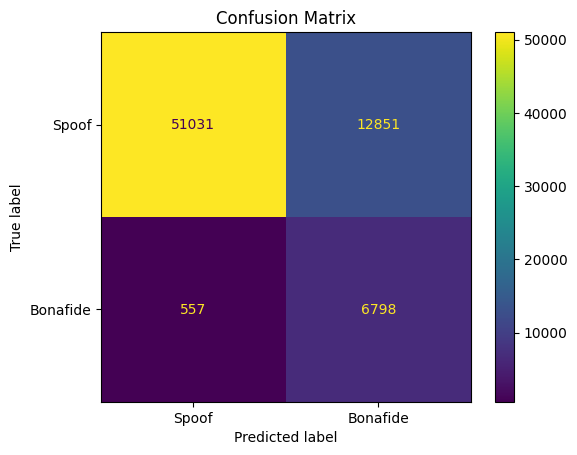

In [11]:
print(f"Model Accuracy on the Test Set: {100 * sklearn.metrics.accuracy_score(labels_test, predictions_test)}%")

cm = sklearn.metrics.confusion_matrix(labels_test, predictions_test)
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Spoof", "Bonafide"])

disp.plot()
plt.title("Confusion Matrix")
plt.show()